In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Load the data
data = pd.read_csv("../data/merged_oil_data.csv", parse_dates=['year', 'month', 'quarter', 'dayofweek'])

C:\Users\huawei\AppData\Local\Temp\ipykernel_6280\4150800065.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/merged_oil_data.csv", parse_dates=['year', 'month', 'quarter', 'dayofweek'])
C:\Users\huawei\AppData\Local\Temp\ipykernel_6280\4150800065.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/merged_oil_data.csv", parse_dates=['year', 'month', 'quarter', 'dayofweek'])
C:\Users\huawei\AppData\Local\Temp\ipykernel_6280\4150800065.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/mer

In [3]:
# Convert the 'year' column to datetime format
data['year'] = pd.to_datetime(data['year'])

In [4]:
# Select the columns you want to use for the VAR model
selected_columns = ['value', 'price', 'percentChange']


In [5]:
# Subset the data with the selected columns
subset_data = data[selected_columns]

VAR (Vector Autoregression) 

In [6]:
# Fit the VAR model
model = VAR(subset_data)
results = model.fit()

# Print the summary of the VAR model
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Jul, 2024
Time:                     20:53:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    26.6396
Nobs:                     27983.0    HQIC:                   26.6372
Log likelihood:          -491785.    FPE:                3.69727e+11
AIC:                      26.6360    Det(Omega_mle):     3.69569e+11
--------------------------------------------------------------------
Results for equation value
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                 1802.370646       539.974223            3.338           0.001
L1.value                 0.923504         0.002293          402.708           0.000
L1.price               -17.347596         6.9387

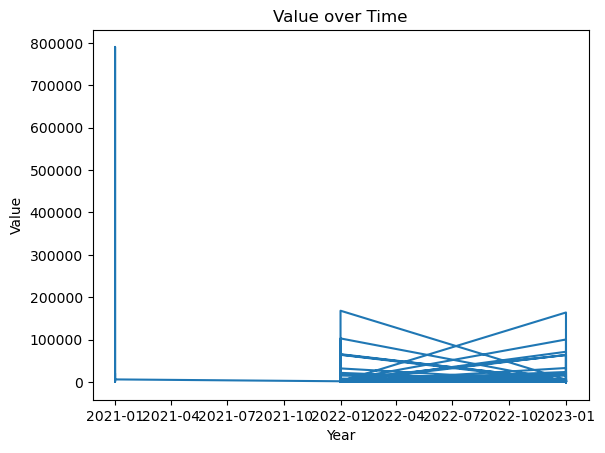

In [8]:
# Plot a line graph of 'value' over time
plt.plot(data['year'], data['value'])
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Value over Time')
plt.show()

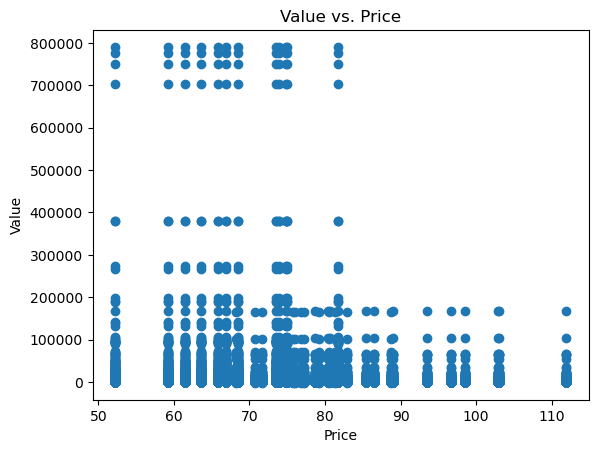

In [9]:
# Plot a scatter plot of 'value' against 'price'
plt.scatter(data['price'], data['value'])
plt.xlabel('Price')
plt.ylabel('Value')
plt.title('Value vs. Price')
plt.show()


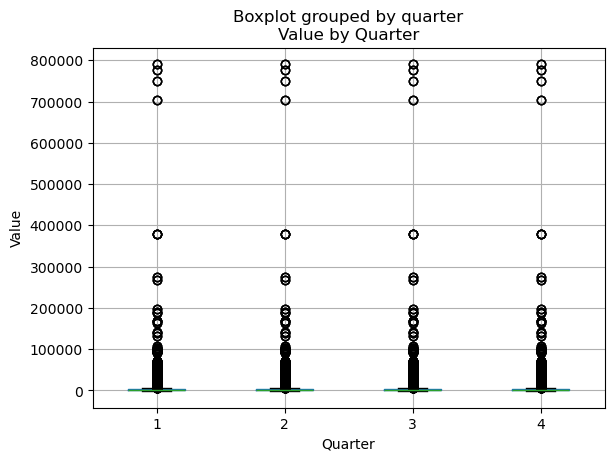

In [10]:
# Create a box plot of 'value' by 'quarter'
data.boxplot(column='value', by='quarter')
plt.xlabel('Quarter')
plt.ylabel('Value')
plt.title('Value by Quarter')
plt.show()

Markov-Switching ARIMA

In [14]:
# Select the column you want to model
target_column = 'value'

# Split the data into train and test sets
train_data, test_data = train_test_split(data[target_column])

In [15]:
# Fit the MS-ARIMA model
model = pm.auto_arima(train_data, seasonal=True, m=12)

# Print the model summary
print(model.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                20988
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood             -229695.441
Date:                            Sun, 07 Jul 2024   AIC                         459396.881
Time:                                    21:06:31   BIC                         459420.736
Sample:                                         0   HQIC                        459404.668
                                          - 20988                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6305      0.000  -1666.625      0.000      -0.631      -0.630
ar.S.L24      -0.3455      0.000   

In [16]:
# Make predictions on the test set
predictions = model.predict(n_periods=len(test_data))

# Evaluate the model performance
mse = ((predictions - test_data) ** 2).mean()
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 113023425.69896299


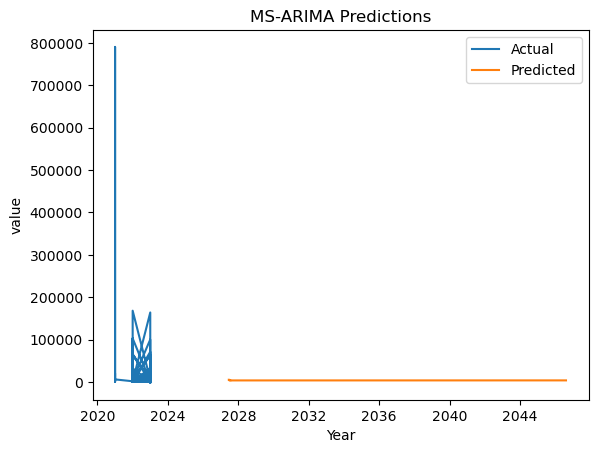

In [17]:
# Plot the predicted values against the actual values
plt.plot(data['year'], data[target_column], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.xlabel('Year')
plt.ylabel(target_column)
plt.title('MS-ARIMA Predictions')
plt.legend()
plt.show()

LSTM (Long Short-Term Memory) 

In [19]:
# Select the column you want to model
target_column = 'value'

# Extract the values from the selected column
values = data[target_column].values.reshape(-1, 1)

# Scale the values to a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

In [20]:
# Split the data into train and test sets
train_size = int(len(scaled_values) * 0.8)
train_data, test_data = scaled_values[:train_size], scaled_values[train_size:]

In [21]:
# Prepare the data for LSTM input
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:i+time_steps, 0])
        Y.append(dataset[i+time_steps, 0])
    return np.array(X), np.array(Y)

In [22]:
time_steps = 3  # Adjust this parameter based on your data
X_train, Y_train = create_dataset(train_data, time_steps)
X_test, Y_test = create_dataset(test_data, time_steps)

In [23]:
# Reshape the input data to match LSTM input shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [24]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\huawei\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Train the LSTM model
model.fit(X_train, Y_train, epochs=10, batch_size=32)

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.2272e-04
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.0078e-04
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.2999e-04
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.0931e-04
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.3998e-04
Epoch 7/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.7238e-04
Epoch 8/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.1699e-04
Epoch 9/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.2061e-04
Epoch 10/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.5625e-04
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


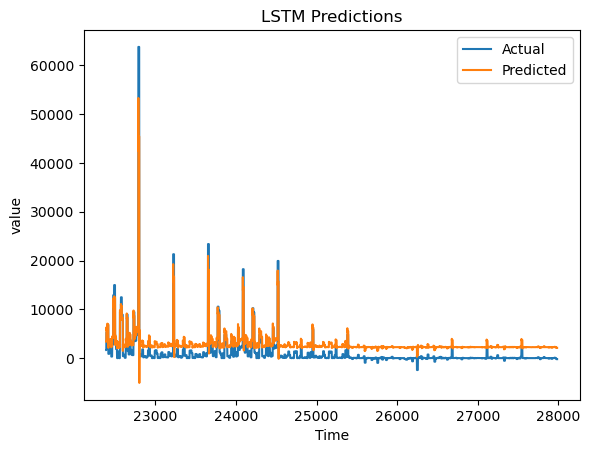

In [26]:
# Plot the predicted values against the actual values
plt.plot(data.index[train_size+time_steps:], data[target_column][train_size+time_steps:], label='Actual')
plt.plot(data.index[train_size+time_steps:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel(target_column)
plt.title('LSTM Predictions')
plt.legend()
plt.show()